In [1]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import mahotas as mt
import pandas as pd
import random

In [2]:
dataset=[]
path = "dataset_full"
label_list = os.listdir(path)
print(label_list)

['Building', 'Forest', 'Glacier', 'Mountain', 'Sea', 'Street']


In [3]:
for i in os.listdir(path):
    in_path = os.path.join(path,i)
    c = 0
    for j in os.listdir(in_path):
        img = cv2.imread(os.path.join(in_path,j))
        dataset.append([img,label_list.index(i),str(j)])
        c+=1
        if c>=500:
            break

In [4]:
random.Random(56).shuffle(dataset)

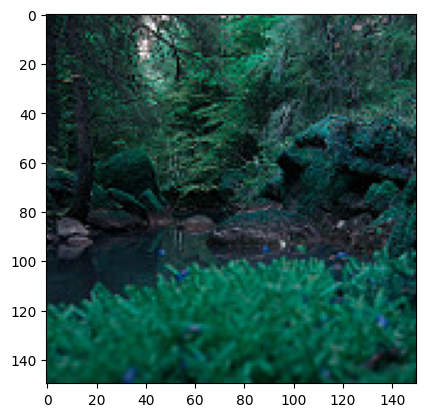

In [5]:
plt.imshow(dataset[1003][0])

In [6]:
dataset[1003][1:]

[1, '12216.jpg']

### Feature Extraction

In [7]:
def Texture_Extraction(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    textures = mt.features.haralick(img)
    return textures.flatten()

def Shape_Extraction(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _,im1 = cv2.threshold(img, 128, 255, cv2.THRESH_BINARY)
    # centre moments
    moment = cv2.moments(im1)
    # hu moments
    huMoment = cv2.HuMoments(moment)
    return huMoment.flatten()

def Color_Extraction(img):
    HSV_image=cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    #for i, col in enumerate(['b', 'g', 'r']):
    hist = cv2.calcHist([HSV_image], [0,1,2], None, [25,25,25], [0,256,0,256,0,256])
    cv2.normalize(hist,hist)
    hist=hist.flatten()
    return hist

In [8]:
Texture=[]
Shape=[]
Color=[]
label=[]
for i in dataset:
    texture_feature = Texture_Extraction(i[0])
    shape_feature = Shape_Extraction(i[0])
    color_feature = Color_Extraction(i[0])
    label.append(i[1])
    Texture.append(texture_feature)
    Shape.append(shape_feature)
    Color.append(color_feature)

In [9]:
np.array(Texture).shape , np.array(Shape).shape , np.array(Color).shape, np.array(label).shape

((3000, 52), (3000, 7), (3000, 15625), (3000,))

In [10]:
Texture=np.array(Texture)
Shape=np.array(Shape)
Color=np.array(Color)

final_data = np.concatenate((Texture,Shape,Color),axis=1)

In [11]:
final_data.shape

(3000, 15684)

In [12]:
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test = train_test_split(final_data,label,test_size=0.3,random_state=150)
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)
Y_train = pd.Series(Y_train)
Y_test = pd.Series(Y_test)

X_train.shape , X_test.shape , Y_train.shape , Y_test.shape

((2100, 15684), (900, 15684), (2100,), (900,))

## Training

In [14]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=10,
                               min_samples_split=20,
                               min_impurity_decrease=0.05)
model.fit(X_train,Y_train)

RandomForestClassifier(min_impurity_decrease=0.05, min_samples_split=20,
                       n_estimators=10)

In [15]:
model.score(X_train,Y_train)

0.30952380952380953

In [16]:
model.score(X_test,Y_test)

0.29333333333333333

---

## RandomizedSearchCV Approach for better Accuracy

In [18]:
parameters = {"n_estimators" : list(np.arange(50,150)),
              "min_samples_split" : list(np.arange(0,100,5)),
              "min_impurity_decrease" : list(np.arange(0.0,0.051,0.001))
                }

In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

model = RandomForestClassifier()
rf_random = RandomizedSearchCV(
                               estimator = model,
                               param_distributions = parameters,
                               n_iter = 100,
                               cv = 3,
                               verbose=2,
                               random_state=42,
                               n_jobs = -1
                              )

rf_random.fit(X_train,Y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'min_impurity_decrease': [0.0, 0.001,
                                                                  0.002, 0.003,
                                                                  0.004, 0.005,
                                                                  0.006, 0.007,
                                                                  0.008,
                                                                  0.009000000000000001,
                                                                  0.01, 0.011,
                                                                  0.012,
                                                                  0.013000000000000001,
                                                                  0.014, 0.015,
                                                                  0.016, 0.017,
                                                                  0.018000000000000002,
                                                                  0.019, 0.02,
                                                                  0.021, 0.022,
                                                                  0.023, 0.024,
                                                                  0.025,
                                                                  0.026000000000000002,
                                                                  0.027, 0.028,
                                                                  0.029, ...],
                                        'min_samples_split': [0, 5, 10, 15, 20,
                                                              25, 30, 35, 40,
                                                              45, 50, 55, 60,
                                                              65, 70, 75, 80,
                                                              85, 90, 95],
                                        'n_estimators': [50, 51, 52, 53, 54, 55,
                                                         56, 57, 58, 59, 60, 61,
                                                         62, 63, 64, 65, 66, 67,
                                                         68, 69, 70, 71, 72, 73,
                                                         74, 75, 76, 77, 78, 79, ...]},
                   random_state=42, verbose=2)

In [20]:
rf_random.best_estimator_

RandomForestClassifier(min_impurity_decrease=0.001, min_samples_split=35,
                       n_estimators=97)

In [21]:
rf_random.score(X_train,Y_train)

0.871904761904762

In [22]:
rf_random.score(X_test,Y_test)

0.6066666666666667

# Final Model

In [23]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=120,
                               min_impurity_decrease=0.001)
model.fit(X_train,Y_train)
model.score(X_train,Y_train)

0.9780952380952381

In [24]:
model.score(X_test,Y_test)

0.6288888888888889

# Testing with Images

### Testing Function

In [13]:
def Testing(path):
    im = cv2.imread(path)
    tex = Texture_Extraction(im)
    sh = Shape_Extraction(im)
    col = Color_Extraction(im)
    fi = np.concatenate((tex,sh,col))
    fi=fi.reshape(1,-1)
    plt.imshow(im)
    return fi

In [31]:
label_list

['Building', 'Forest', 'Glacier', 'Mountains', 'Sea', 'Streets']

'Building'

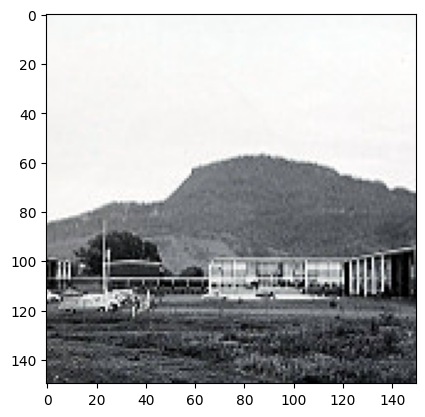

In [25]:
label_list[model.predict(Testing("dataset_full/Building/0.jpg"))[0]]

'Forest'

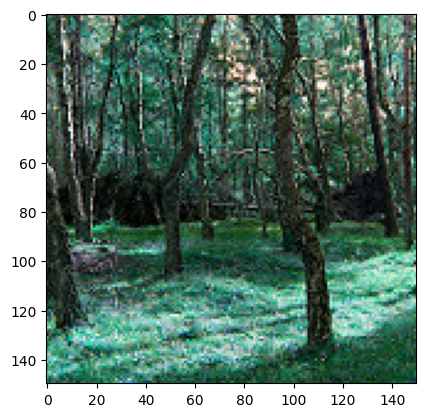

In [26]:
label_list[model.predict(Testing("dataset_full/Forest/10030.jpg"))[0]]